Total Number of Samples: 454684
Unique Artworks: 80031
Average Caption Length: 15.69 words


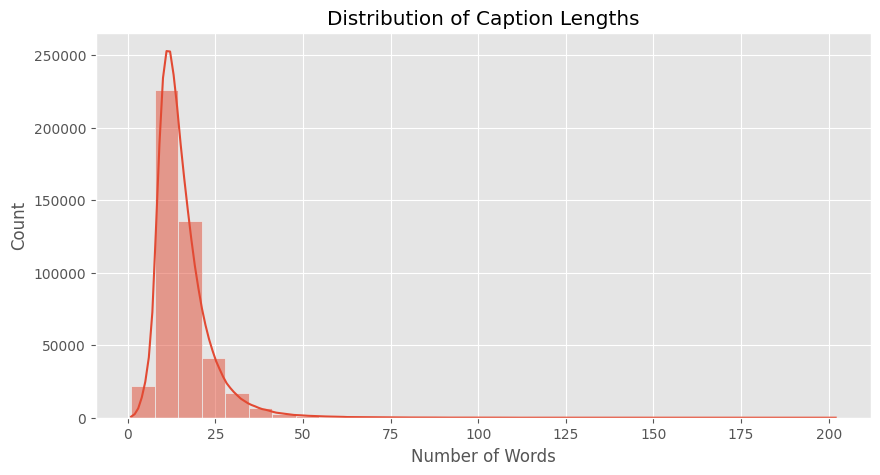

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
import os
from PIL import Image

# Setup
# nltk.download('punkt') # Uncomment if not downloaded
plt.style.use('ggplot')

# Load the dataset
# Assuming columns: 'art_style', 'painting', 'emotion', 'utterance' (standard ArtEmis format)
# Adjust column names if your CSV is different.
df = pd.read_csv("captions.csv") 

# 1. Basic Counts
print(f"Total Number of Samples: {len(df)}")
print(f"Unique Artworks: {df['painting'].nunique()}")

# 2. Caption Length Analysis
df['caption_length'] = df['utterance'].apply(lambda x: len(str(x).split()))
avg_len = df['caption_length'].mean()
print(f"Average Caption Length: {avg_len:.2f} words")

# Plot Caption Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['caption_length'], bins=30, kde=True)
plt.title("Distribution of Caption Lengths")
plt.xlabel("Number of Words")
plt.show()

Vocabulary Size (unique words): 99870


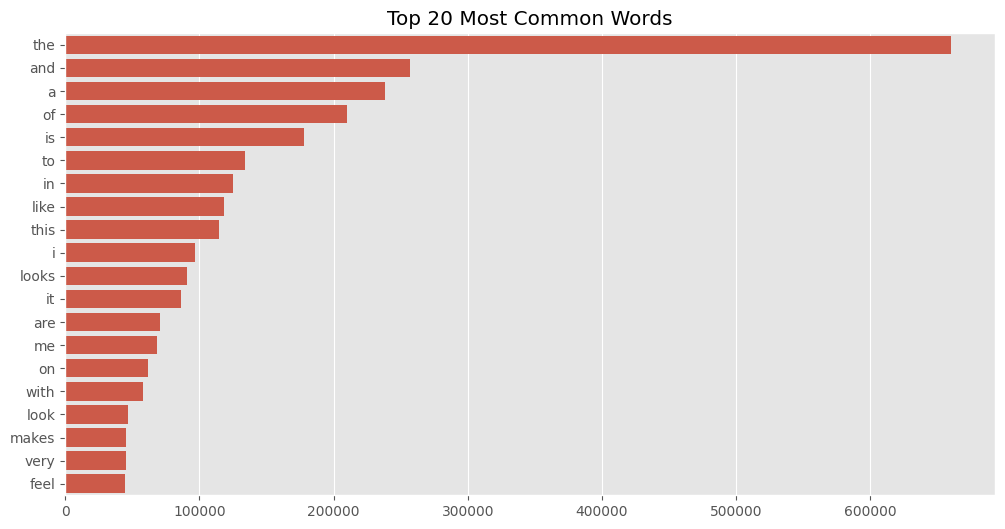

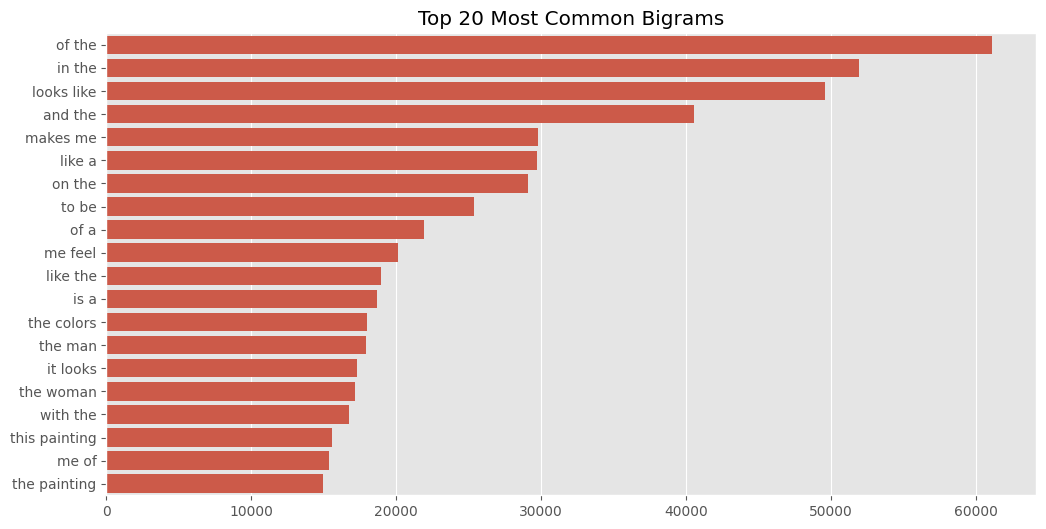

In [2]:
# Helper function to get top N-grams
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = []
    for text in corpus:
        tokens = str(text).lower().split()
        # Create n-grams
        if len(tokens) >= n:
            vec.extend(list(ngrams(tokens, n)))
            
    # Count frequency
    counter = Counter(vec)
    return counter.most_common(top_k)

# 1. Vocabulary Size
all_words = [word for caption in df['utterance'] for word in str(caption).lower().split()]
vocab_size = len(set(all_words))
print(f"Vocabulary Size (unique words): {vocab_size}")

# 2. Top 20 Words (Unigrams)
top_words = get_top_ngrams(df['utterance'], n=1, top_k=20)
words, counts = zip(*top_words)
words = [w[0] for w in words] # Extract word from tuple

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Common Words")
plt.show()

# 3. Top 20 Bigrams (Two-word combinations)
top_bigrams = get_top_ngrams(df['utterance'], n=2, top_k=20)
bigrams, counts = zip(*top_bigrams)
bigrams = [" ".join(b) for b in bigrams]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(bigrams))
plt.title("Top 20 Most Common Bigrams")
plt.show()

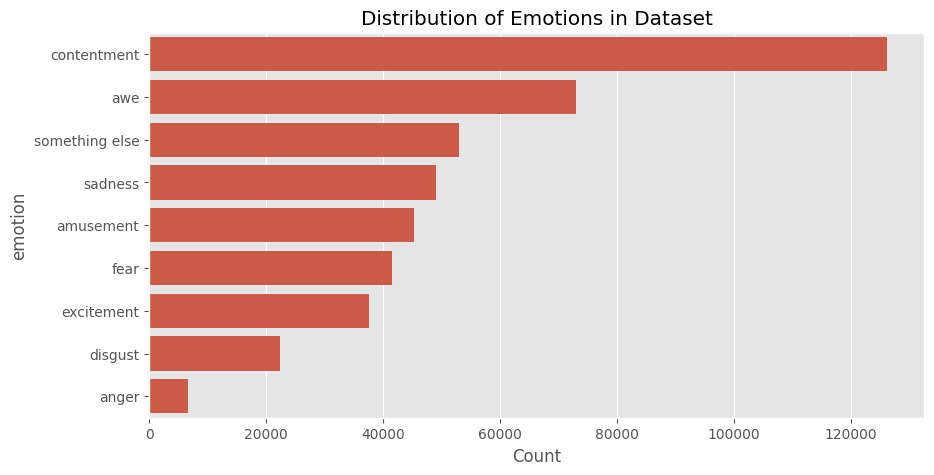

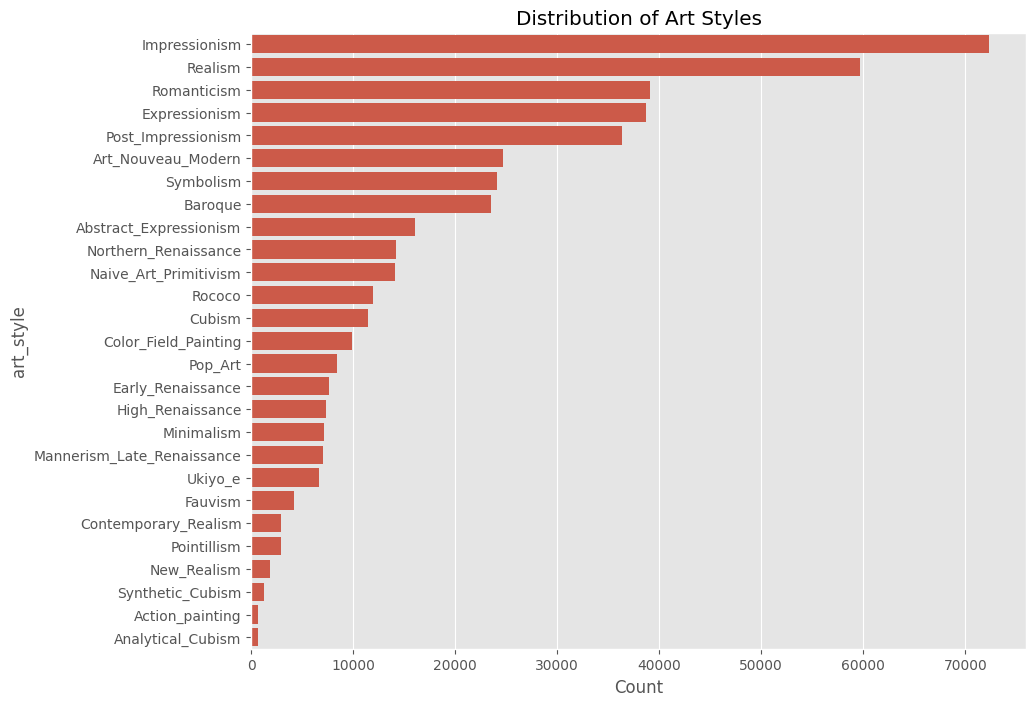

In [3]:
# 1. Emotion Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Distribution of Emotions in Dataset")
plt.xlabel("Count")
plt.show()

# 2. Art Style Distribution
# This checks if your subset is biased towards one style (e.g., Impressionism)
plt.figure(figsize=(10, 8))
sns.countplot(y='art_style', data=df, order=df['art_style'].value_counts().index)
plt.title("Distribution of Art Styles")
plt.xlabel("Count")
plt.show()


Sample 1: The faces look misshapen and the proportions are off.
Sample 2: the scene is busy with people who are engaged with one another and their activities
Sample 3: I really just do not like seeing a lot of people, especially when they all are blank faced and nondescript. It gives me the bad kind of existential feelings.


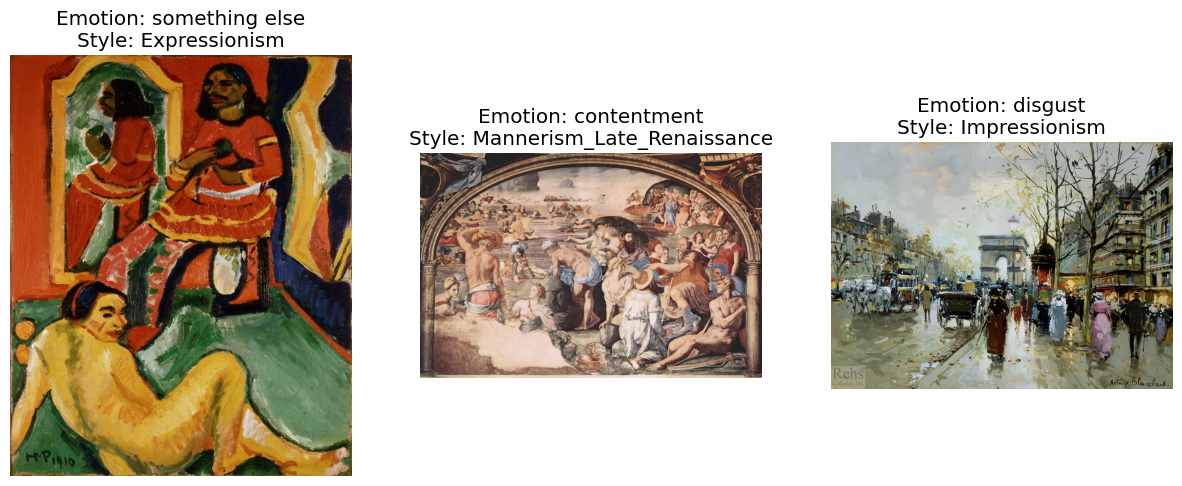

In [3]:
import random

def visualize_samples(df, image_folder, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    # Sample random rows
    samples = df.sample(num_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img_name = row['painting'] # Or 'image_file' depending on your CSV
        caption = row['utterance']
        emotion = row['emotion']
        style = row['art_style']
        
        # Load image
        img_path = os.path.join(image_folder, style, img_name + ".jpg") 
        # Note: ArtEmis folder structure is usually style/painting.jpg. 
        # Adjust path logic if your images are all in one folder.
        
        try:
            image = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(f"Emotion: {emotion}\nStyle: {style}")
            plt.axis("off")
            
            # Print caption below
            print(f"Sample {i+1}: {caption}")
        except FileNotFoundError:
            print(f"Could not find image: {img_path}")

    plt.show()

# Run visualization
# Replace "wikiart/" with the actual path to your images folder
visualize_samples(df, image_folder="wikiart/", num_samples=3)

# 3. Preprocessing

Initializing Vocabulary and DataLoader...
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
✅ Preprocessing Complete.
Vocabulary Size: 1645 words
Number of Batches: 188


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Batch Verification ---
Image Batch Shape: torch.Size([32, 3, 224, 224])
Caption Batch Shape: torch.Size([32, 46])
Emotion Batch Shape: torch.Size([32])


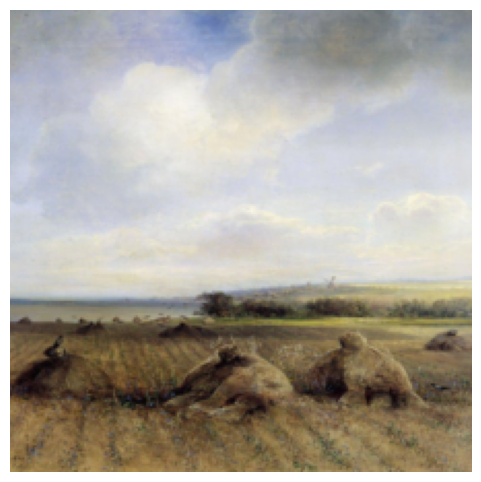

Ground Truth Caption: this painting has amazing detail in the grass and it has great depth
Emotion Label: contentment


In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from preprocessing import get_loader, EMOTION_MAP # Import EMOTION_MAP directly

# --- 1. Configuration & Constants ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

IMAGE_FOLDER = "./wikiart/"   
CAPTIONS_FILE = "captions.csv" 
BATCH_SIZE = 32

# --- 2. Initialize Data Loaders ---
print("Initializing Vocabulary and DataLoader...")
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"✅ Preprocessing Complete.")
print(f"Vocabulary Size: {len(train_dataset.vocab)} words")
print(f"Number of Batches: {len(train_loader)}")

# --- 3. Sanity Check (Verification) ---
images, captions, emotions = next(iter(train_loader)) 

print("\n--- Batch Verification ---")
print(f"Image Batch Shape: {images.shape}")    # Expected: [32, 3, 224, 224]
print(f"Caption Batch Shape: {captions.shape}")
print(f"Emotion Batch Shape: {emotions.shape}")

# --- 4. Visual Proof ---
def decode_caption(caption_indices, vocab):
    words = []
    for idx in caption_indices:
        word = vocab.itos[idx.item()]
        if word == "<start>": continue
        if word == "<end>": break
        words.append(word)
    return " ".join(words)

# Create the reverse map correctly using the imported dictionary
idx_to_emotion = {v: k for k, v in EMOTION_MAP.items()}

# Display the first image
plt.figure(figsize=(6, 6))
plt.imshow(images[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

# Decode and print text
decoded_text = decode_caption(captions[0], train_dataset.vocab)
emotion_str = idx_to_emotion.get(emotions[0].item(), "Unknown")

print(f"Ground Truth Caption: {decoded_text}")
print(f"Emotion Label: {emotion_str}")

In [5]:
from preprocessing import create_tfidf_embeddings_from_scratch

# 1. Get the raw text from the dataset
# We need the list of strings, not the tensors
all_captions = train_dataset.captions 

# 2. Define embedding dimension (must match your future LSTM settings)
EMBED_DIM = 256 

# 3. Compute the matrix
print("--- Generating TF-IDF Embeddings ---")
tfidf_weights = create_tfidf_embeddings_from_scratch(
    captions=all_captions, 
    vocab=train_dataset.vocab, 
    embed_dim=EMBED_DIM
)

print(f"✅ TF-IDF Weights Ready. Shape: {tfidf_weights.shape}")
# Expected shape: (Vocab_Size, 256)

--- Generating TF-IDF Embeddings ---
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...
✅ TF-IDF Weights Ready. Shape: torch.Size([1645, 256])


In [6]:
import torch.optim as optim
import time
import os

# Import your custom modules
# %load_ext autoreload
# %autoreload 2
from preprocessing import get_loader, create_tfidf_embeddings_from_scratch, load_pretrained_vectors
from model import CustomImageCaptionModel 

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Paths (Adjust these if your file names differ)
IMAGE_FOLDER = "./wikiart/"
CAPTIONS_FILE = "captions.csv"
GLOVE_PATH = "glove.6B.300d.txt"       # Ensure this file exists
FASTTEXT_PATH = "wiki-news-300d-1M.vec" # Ensure this file exists

Device: cpu


In [7]:
# Hyperparameters for Data Loading
BATCH_SIZE = 32
VOCAB_THRESHOLD = 5

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

print("--- Loading Data ---")
train_loader, train_dataset = get_loader(
    root_folder=IMAGE_FOLDER,
    annotation_file=CAPTIONS_FILE,
    transform=transform,
    batch_size=BATCH_SIZE,
    shuffle=True
)

VOCAB_SIZE = len(train_dataset.vocab)
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Number of Batches: {len(train_loader)}")

--- Loading Data ---
Dataset too large (454684). Subsetting to 6000 samples for efficiency.
Vocabulary Size: 1645
Number of Batches: 188


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_experiment(experiment_name, embedding_weights, embed_dim, num_epochs=5):
    print(f"\n\n{'='*20}")
    print(f"STARTING EXPERIMENT: {experiment_name}")
    print(f"{'='*20}")
    
    # 1. Initialize Model
    model = CustomImageCaptionModel(
        embed_size=embed_dim,
        hidden_size=256, 
        vocab_size=VOCAB_SIZE,
        embedding_weights=embedding_weights
    ).to(device)
    
    # 2. Loss and Optimizer
    pad_idx = train_dataset.vocab.stoi["<pad>"]
    
    # nn is now guaranteed to be defined
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 3. Training Loop
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        
        for batch_idx, (images, captions, emotions) in enumerate(train_loader):
            # Move to device
            images = images.to(device)
            captions = captions.to(device)
            emotions = emotions.to(device)
            
            # Prepare Targets
            inputs = captions[:, :-1]
            targets = captions[:, 1:]
            
            # Forward Pass
            outputs = model(images, inputs, emotions)
            
            # Calculate Loss
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}], Loss: {loss.item():.4f}")
        
        # Epoch Stats
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        elapsed = time.time() - start_time
        print(f"✅ Epoch {epoch+1} Complete. Avg Loss: {avg_loss:.4f}. Time: {elapsed:.1f}s")
        
    # 4. Save Model
    save_path = f"model_{experiment_name}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    return loss_history

In [9]:
from preprocessing import create_tfidf_embeddings_from_scratch, load_pretrained_vectors

# Configuration
NUM_EPOCHS = 15 
results = {}

# --- RUN 1: TF-IDF [cite: 51] ---
print("Generating TF-IDF Embeddings...")
tfidf_dim = 256
tfidf_weights = create_tfidf_embeddings_from_scratch(
    train_dataset.captions, 
    train_dataset.vocab, 
    embed_dim=tfidf_dim
)

results['TF-IDF'] = train_experiment(
    experiment_name="TF-IDF",
    embedding_weights=tfidf_weights,
    embed_dim=tfidf_dim,
    num_epochs=NUM_EPOCHS
)

# --- RUN 2: GloVe [cite: 57] ---
print("\nLoading GloVe Embeddings...")
glove_dim = 300
glove_weights = load_pretrained_vectors(
    train_dataset.vocab, 
    GLOVE_PATH, 
    embed_dim=glove_dim
)

results['GloVe'] = train_experiment(
    experiment_name="GloVe",
    embedding_weights=glove_weights,
    embed_dim=glove_dim,
    num_epochs=NUM_EPOCHS
)

# --- RUN 3: FastText [cite: 58] ---
print("\nLoading FastText Embeddings...")
fasttext_dim = 300
fasttext_weights = load_pretrained_vectors(
    train_dataset.vocab, 
    FASTTEXT_PATH, 
    embed_dim=fasttext_dim
)

results['FastText'] = train_experiment(
    experiment_name="FastText",
    embedding_weights=fasttext_weights,
    embed_dim=fasttext_dim,
    num_epochs=NUM_EPOCHS
)

Generating TF-IDF Embeddings...
Step 1: Computing Document Frequencies...
Step 2: Computing IDF...
Step 3: Creating Sparse TF-IDF Matrix...
Step 4: Dimensionality Reduction to 256...


STARTING EXPERIMENT: TF-IDF


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15], Step [0], Loss: 7.4149
Epoch [1/15], Step [50], Loss: 5.3890


/Users/ape/Documents/Ashoka/Monsoon 2025/Introduction to Machine Learning/Assignments/Assignment 3/venv/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/15], Step [100], Loss: 5.3463
Epoch [1/15], Step [150], Loss: 5.3497
✅ Epoch 1 Complete. Avg Loss: 5.4646. Time: 222.6s
Epoch [2/15], Step [0], Loss: 5.3054
Epoch [2/15], Step [50], Loss: 5.3498
Epoch [2/15], Step [100], Loss: 5.2758
Epoch [2/15], Step [150], Loss: 5.2857
✅ Epoch 2 Complete. Avg Loss: 5.3120. Time: 243.2s
Epoch [3/15], Step [0], Loss: 5.2712
Epoch [3/15], Step [50], Loss: 5.2130
Epoch [3/15], Step [100], Loss: 5.3675
Epoch [3/15], Step [150], Loss: 5.3590
✅ Epoch 3 Complete. Avg Loss: 5.2979. Time: 247.6s
Epoch [4/15], Step [0], Loss: 5.2741
Epoch [4/15], Step [50], Loss: 5.2920
Epoch [4/15], Step [100], Loss: 5.2487
Epoch [4/15], Step [150], Loss: 5.3093
✅ Epoch 4 Complete. Avg Loss: 5.2891. Time: 246.0s
Epoch [5/15], Step [0], Loss: 5.3386
Epoch [5/15], Step [50], Loss: 5.4490
Epoch [5/15], Step [100], Loss: 5.1078
Epoch [5/15], Step [150], Loss: 5.1177
✅ Epoch 5 Complete. Avg Loss: 5.2807. Time: 251.5s
Epoch [6/15], Step [0], Loss: 5.2474
Epoch [6/15], Step

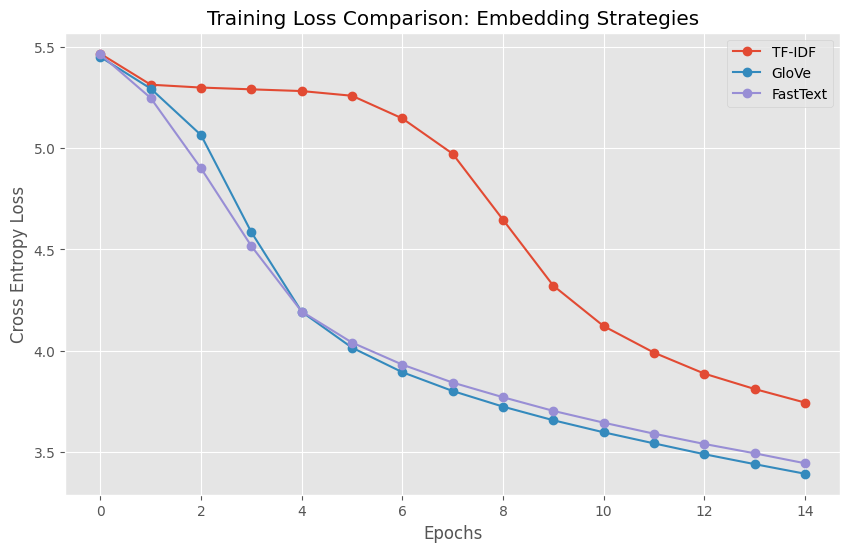

In [10]:

plt.figure(figsize=(10, 6))

for name, losses in results.items():
    plt.plot(losses, label=name, marker='o')

plt.title("Training Loss Comparison: Embedding Strategies")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import torch.nn.functional as F

def generate_caption(model, image, emotion_idx, dataset, max_len=20, temperature=0.8):
    """
    Generates a caption using Temperature Sampling to fix repetition loops.
    temperature: Lower (0.5) = More confident/repetitive. Higher (1.0) = More random/diverse.
    """
    model.eval()
    vocab = dataset.vocab
    
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        emotion = torch.tensor([emotion_idx]).to(device)
        
        img_features = model.forward_encoder(image)
        emo_features = model.emotion_embed(emotion)
        context = torch.cat((img_features, emo_features), dim=1)
        
        h = torch.zeros(1, model.lstm.hidden_size).to(device)
        c = torch.zeros(1, model.lstm.hidden_size).to(device)
        states = (h, c)
        
        start_token = vocab.stoi["<start>"]
        current_word_idx = torch.tensor([start_token]).to(device)
        
        captions_ids = []
        
        for _ in range(max_len):
            word_embed = model.embed(current_word_idx)
            lstm_input = torch.cat((context, word_embed), dim=1).unsqueeze(1)
            
            output, states = model.lstm(lstm_input, states)
            prediction = model.linear(output.squeeze(1)) # (1, Vocab_Size)
            
            # --- FIX: SAMPLING INSTEAD OF ARGMAX ---
            # 1. Apply Temperature (Sharpen/Flatten distribution)
            prediction = prediction / temperature
            
            # 2. Convert to Probabilities
            probs = F.softmax(prediction, dim=1)
            
            # 3. Sample from distribution
            predicted_id = torch.multinomial(probs, num_samples=1)
            # ---------------------------------------
            
            if predicted_id.item() == vocab.stoi["<end>"]:
                break
                
            captions_ids.append(predicted_id.item())
            current_word_idx = predicted_id.squeeze(0) # Update input
            
        return [vocab.itos[idx] for idx in captions_ids]

In [20]:
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_score(model, loader, dataset, num_batches=5):
    """
    Calculates BLEU-1 score on a subset of the data.
    """
    print("--- Calculating BLEU Score ---")
    model.eval()
    
    # 1. Initialize Smoothing (Fixes the NameError)
    # This handles cases where there is 0 overlap for higher n-grams
    chencherry = SmoothingFunction()
    
    total_bleu = 0
    count = 0
    
    device = next(model.parameters()).device

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_batches:
                break
            
            # 2. Unpack the 3 inputs (Fixes the potential future TypeError)
            images = batch[0].to(device)
            captions = batch[1].to(device)
            emotions = batch[2].to(device) 

            # 3. Forward Pass (Conditioned on Emotion)
            outputs = model(images, captions, emotions)
            predictions = outputs.argmax(dim=2)

            # 4. Calculate Score per sentence in batch
            for j in range(len(captions)):
                # Convert indices to words
                pred_indices = predictions[j].cpu().tolist()
                true_indices = captions[j].cpu().tolist()
                
                # Filter padding (0) and Start/End tokens if necessary
                # We stick to simple filtering of 0 for now
                pred_words = [str(idx) for idx in pred_indices if idx != 0]
                true_words = [str(idx) for idx in true_indices if idx != 0]
                
                # BLEU expects a list of reference sentences (we have 1 reference)
                # and 1 candidate sentence.
                score = sentence_bleu(
                    [true_words], 
                    pred_words, 
                    weights=(1, 0, 0, 0), # BLEU-1 (Unigram precision only)
                    smoothing_function=chencherry.method1
                )
                
                total_bleu += score
                count += 1
                
    avg_bleu = total_bleu / count
    print(f"Average BLEU-1 Score: {avg_bleu:.4f}")
    model.train()

In [23]:
import torch
import matplotlib.pyplot as plt

def evaluate_model_visual(model, loader, dataset, num_samples=2):
    print("--- Visualizing Model Predictions (Emotion Conditioned) ---")
    model.eval()
    
    batch = next(iter(loader))
    images = batch[0]
    captions = batch[1]
    emotions = batch[2]
    
    device = next(model.parameters()).device
    images = images.to(device)
    captions = captions.to(device)
    emotions = emotions.to(device)

    with torch.no_grad():
        output = model(images, captions, emotions)
        predictions = output.argmax(dim=2) 
    
    # --- DYNAMIC VOCABULARY DETECTION ---
    # We try to find the dictionary that converts Index -> Word
    idx2word = None
    
    # Check 1: dataset.vocab.idx2word (Standard)
    if hasattr(dataset, 'vocab') and hasattr(dataset.vocab, 'idx2word'):
        idx2word = dataset.vocab.idx2word
    # Check 2: dataset.idx2word (Direct attribute)
    elif hasattr(dataset, 'idx2word'):
        idx2word = dataset.idx2word
    # Check 3: dataset.vocab.itos (TorchText convention: Integer-to-String)
    elif hasattr(dataset, 'vocab') and hasattr(dataset.vocab, 'itos'):
        idx2word = dataset.vocab.itos
    # Check 4: dataset.index_to_word (Common custom name)
    elif hasattr(dataset, 'index_to_word'):
        idx2word = dataset.index_to_word

    if idx2word is None:
        print("\nCRITICAL ERROR: Could not find the vocabulary dictionary.")
        print("Please check 'train_dataset' and tell me the attribute name for index-to-word.")
        print(f"Available attributes: {dataset.__dict__.keys()}")
        return

    for i in range(num_samples):
        plt.figure(figsize=(4, 4))
        img_disp = images[i].cpu().permute(1, 2, 0).numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        
        plt.imshow(img_disp)
        plt.axis("off")
        plt.show()
        
        pred_indices = predictions[i].cpu().tolist()
        true_indices = captions[i].cpu().tolist()
        emotion_val = emotions[i].item()
        
        # decoding
        pred_text = []
        for idx in pred_indices:
            if idx != 0: # Skip padding
                # Handle list-based (itos) vs dict-based (idx2word) lookup
                word = idx2word[idx] if isinstance(idx2word, (dict, list)) else "ERR"
                pred_text.append(word)
                
        true_text = []
        for idx in true_indices:
            if idx != 0:
                word = idx2word[idx] if isinstance(idx2word, (dict, list)) else "ERR"
                true_text.append(word)

        print(f"Sample {i+1}")
        print(f"Conditioned Emotion Index: {emotion_val}") 
        print(f"Predicted:    {' '.join(pred_text)}")
        print(f"Ground Truth: {' '.join(true_text)}")
        print("-" * 60)

    model.train()


TESTING MODEL: TF-IDF
Weights loaded successfully.
--- Visualizing Model Predictions (Emotion Conditioned) ---


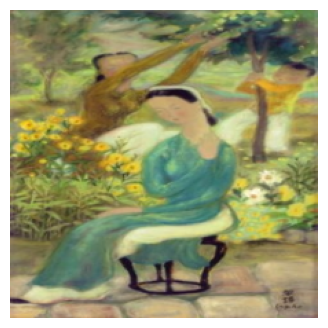

Sample 1
Conditioned Emotion Index: 7
Predicted:    the are the is <unk> looks <unk> <end> be the <unk> is <end> the face <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> children in background <unk> it is best to leave the woman alone in her <unk> <end>
------------------------------------------------------------


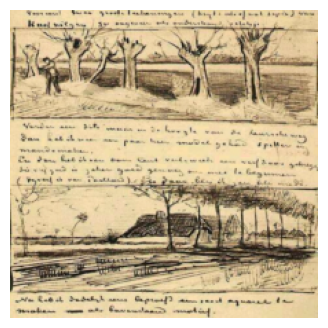

Sample 2
Conditioned Emotion Index: 2
Predicted:    the is like a <unk> a <unk> and <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> this seems like <unk> for a farm being <unk> <end>
------------------------------------------------------------
--- Calculating BLEU Score ---
Average BLEU-1 Score: 0.1521

TESTING MODEL: GloVe
Weights loaded successfully.
--- Visualizing Model Predictions (Emotion Conditioned) ---


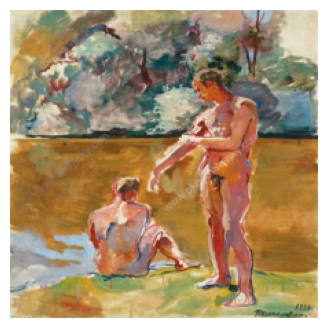

Sample 1
Conditioned Emotion Index: 2
Predicted:    the people man are <unk> and the <unk> <end> the <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> two young men are relaxing by the pond in the park <end>
------------------------------------------------------------


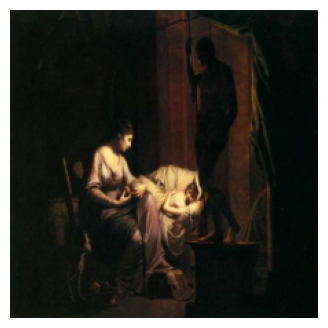

Sample 2
Conditioned Emotion Index: 7
Predicted:    the <unk> in the looks like be <unk> and he <unk> <unk> <end> the <end> me seem to she is <unk> <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
Ground Truth: <start> the child in bed looks to be <unk> but the light <unk> over him makes it appear that he is in good hands <end>
------------------------------------------------------------
--- Calculating BLEU Score ---
Average BLEU-1 Score: 0.1570

TESTING MODEL: FastText
Weights loaded successfully.
--- Visualizing Model Predictions (Emotion Conditioned) ---


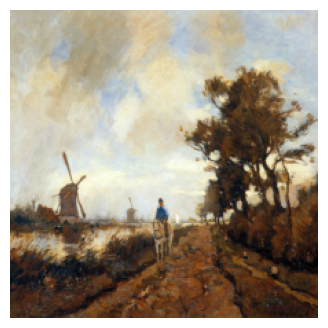

Sample 1
Conditioned Emotion Index: 8
Predicted:    the is <unk> <unk> <unk> <unk> <unk> <end> the <end> <end> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Ground Truth: <start> he takes the long and <unk> road all alone <end>
------------------------------------------------------------


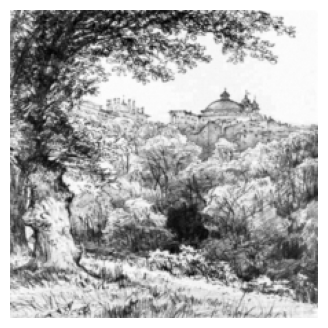

Sample 2
Conditioned Emotion Index: 2
Predicted:    the <unk> and in the and the make like <end> <end> <unk> <unk> is the water <end> a <unk> <end> i <unk> away <end> <end> a <unk> <unk> <unk> <unk> <unk>
Ground Truth: <start> the hills covered in trees and <unk> looks <unk> natural and the building on the hill suggests something important but still far away <end>
------------------------------------------------------------
--- Calculating BLEU Score ---
Average BLEU-1 Score: 0.1631


In [24]:
# Constants for reloading
VOCAB_SIZE = len(train_dataset.vocab)

# List of your experiments
saved_models = [
    ("TF-IDF", "model_TF-IDF.pt", 256),
    ("GloVe", "model_GloVe.pt", 300),
    ("FastText", "model_FastText.pt", 300)
]

for name, path, dim in saved_models:
    print(f"\n{'='*30}")
    print(f"TESTING MODEL: {name}")
    print(f"{'='*30}")
    
    # 1. Initialize empty model architecture
    model_test = CustomImageCaptionModel(
        embed_size=dim,
        hidden_size=256,
        vocab_size=VOCAB_SIZE,
        embedding_weights=None # We load weights from state_dict, so None is fine here
    ).to(device)
    
    # 2. Load the trained weights
    try:
        model_test.load_state_dict(torch.load(path, map_location=device))
        print("Weights loaded successfully.")
    except FileNotFoundError:
        print(f"Model file {path} not found. Skipping.")
        continue

    # 3. Qualitative: Show images
    evaluate_model_visual(model_test, train_loader, train_dataset, num_samples=2)
    
    # 4. Quantitative: BLEU Score
    calculate_bleu_score(model_test, train_loader, train_dataset, num_batches=5)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# A helper to generate the "Look-Ahead" mask
# This ensures the decoder cannot see future words when training.
def generate_square_subsequent_mask(sz, device):
    # Creates a matrix where upper triangle is -inf, lower is 0
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(device)

In [26]:
class CustomMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads 
        
        # 1. Weights for Query, Key, Value
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # 2. Score Calculation: (Q @ K_transpose) / sqrt(d_k)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 3. Apply Mask (if provided, e.g., for Decoder)
        if mask is not None:
            # We assume mask shape matches or broadcasts to attn_scores
            attn_scores = attn_scores.masked_fill(mask == float('-inf'), float('-inf'))
        
        # 4. Probability Distribution
        attn_probs = F.softmax(attn_scores, dim=-1)
        
        # 5. Weighted Sum
        output = torch.matmul(attn_probs, V)
        return output

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear Projections
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Split Heads: (Batch, Seq_Len, d_model) -> (Batch, Heads, Seq_Len, d_k)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Attention
        output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate Heads
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.W_o(output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: (Batch, Seq_Len, d_model)
        return x + self.pe[:, :x.size(1)]

In [27]:
class CustomPatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Input vector size = 16*16*3 = 768
        self.input_dim = patch_size * patch_size * in_channels
        self.projection = nn.Linear(self.input_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        # Force resize if image is wrong size
        if H != self.img_size:
            x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear')
            
        # 1. Flatten Patches (The "Scratch" way)
        # Unfold extracts sliding blocks. We define stride=patch_size for non-overlapping blocks.
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 3, 4, 1).contiguous().view(B, -1, self.input_dim)
        
        # 2. Project to Embedding Dimension
        x = self.projection(patches)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model))
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self Attention -> Add -> Norm
        attn_out = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        # Feed Forward -> Add -> Norm
        ff_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class ViTEncoder(nn.Module):
    def __init__(self, img_size, patch_size, d_model, num_layers, num_heads, d_ff):
        super().__init__()
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, embed_dim=d_model)
        
        # Emotion Embedding (Projects emotion index 0-9 to vector)
        self.emotion_embed = nn.Embedding(10, d_model)
        
        # Positional Embedding (Learnable)
        self.num_patches = (img_size // patch_size) ** 2
        # +1 for the emotion token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
        
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.dropout = nn.Dropout(0.1)

    def forward(self, images, emotions):
        # 1. Patchify Image
        x = self.patch_embed(images) # (Batch, 196, d_model)
        
        # 2. Prepend Emotion Token
        emo = self.emotion_embed(emotions).unsqueeze(1) # (Batch, 1, d_model)
        x = torch.cat((emo, x), dim=1) # (Batch, 197, d_model)
        
        # 3. Add Position Info
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)
        
        # 4. Apply Encoder Layers
        for layer in self.layers:
            x = layer(x)
        return x

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        
        self.cross_attn = CustomMultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model))
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask):
        # 1. Masked Self-Attention (Look at past words)
        attn_out = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        # 2. Cross-Attention (Look at Image Patches)
        # Query=Text, Key=Image, Value=Image
        attn_out = self.cross_attn(query=x, key=enc_output, value=enc_output)
        x = self.norm2(x + self.dropout(attn_out))
        
        # 3. Feed Forward
        ff_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ff_out))
        return x

In [29]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_layers=2, 
                 patch_size=16, img_size=224, d_ff=512, max_len=100):
        super().__init__()
        
        # Encoder
        self.encoder = ViTEncoder(img_size, patch_size, d_model, num_layers, num_heads, d_ff)
        
        # Decoder Setup
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.d_model = d_model

    def forward(self, images, captions, emotions):
        # 1. Encode Image + Emotion
        enc_output = self.encoder(images, emotions)
        
        # 2. Prepare Captions
        seq_len = captions.size(1)
        # Create look-ahead mask
        tgt_mask = generate_square_subsequent_mask(seq_len, images.device)
        
        # Embed + Positional Encoding
        tgt = self.embedding(captions) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        tgt = self.dropout(tgt)
        
        # 3. Decode
        x = tgt
        for layer in self.decoder_layers:
            x = layer(x, enc_output, tgt_mask)
            
        # 4. Output
        return self.fc_out(x)

In [30]:
# Hyperparameters
# Using smaller numbers to ensure it runs fast for your deadline
D_MODEL = 256
NUM_HEADS = 4
NUM_LAYERS = 2
BATCH_SIZE = 32

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(train_dataset.vocab) # Ensure this matches your dataset

model = TransformerModel(vocab_size=vocab_size, d_model=D_MODEL, num_heads=NUM_HEADS, num_layers=NUM_LAYERS).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignore padding
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print("Transformer Model Initialized Successfully.")

# --- Training Snippet (Replace your old loop with this logic) ---
# for images, captions, emotions in train_loader:
#     images, captions, emotions = images.to(device), captions.to(device), emotions.to(device)
#
#     # Inputs: Full caption (including <start> and <end>)
#     # Targets: Shifted by 1 (Predict next word)
#     input_captions = captions[:, :-1]
#     target_captions = captions[:, 1:]
#
#     optimizer.zero_grad()
#     outputs = model(images, input_captions, emotions)
#
#     # Reshape for Loss
#     # Output: (Batch, Seq_Len, Vocab) -> (Batch * Seq_Len, Vocab)
#     # Target: (Batch, Seq_Len) -> (Batch * Seq_Len)
#     loss = criterion(outputs.reshape(-1, vocab_size), target_captions.reshape(-1))
#
#     loss.backward()
#     optimizer.step()

Transformer Model Initialized Successfully.


In [31]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_transformer(model, train_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignore padding (0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    device = next(model.parameters()).device
    
    loss_history = []
    
    print(f"--- Starting Transformer Training on {device} ---")
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, captions, emotions) in enumerate(train_loader):
            images, captions, emotions = images.to(device), captions.to(device), emotions.to(device)
            
            # --- THE TRAINING OBJECTIVE (SHIFTED TARGETS) ---
            # Input:  "<start> A cat is sitting"
            # Target: "A cat is sitting <end>"
            
            # 1. Prepare Input (Everything except the last token)
            input_captions = captions[:, :-1]
            
            # 2. Prepare Target (Everything except the first token)
            target_captions = captions[:, 1:]
            
            optimizer.zero_grad()
            
            # 3. Forward Pass
            # The model internally creates the Look-Ahead mask for input_captions
            outputs = model(images, input_captions, emotions)
            
            # 4. Calculate Loss
            # Reshape output to (Batch * Seq_Len, Vocab_Size)
            # Reshape target to (Batch * Seq_Len)
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), target_captions.reshape(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")
        
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"--- Epoch {epoch+1} Complete. Average Loss: {avg_loss:.4f} ---")

    # --- PLOT LOSS CURVE (Assignment Requirement) ---
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Transformer Training Objective Convergence')
    plt.legend()
    plt.show()
    
    return model

# RUN THE TRAINING
# model_transformer = train_transformer(model_transformer, train_loader, num_epochs=5)

In [34]:
import torch
import math

# 1. Ensure the helper function is defined (in case it wasn't in scope)
def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(device)

# 2. Corrected Generation Function
def generate_caption_transformer(model, image, emotion, dataset, max_len=20):
    model.eval()
    device = next(model.parameters()).device
    
    # Prepare Inputs
    image = image.unsqueeze(0).to(device)     # (1, C, H, W)
    emotion = torch.tensor([emotion]).to(device) # (1)
    
    # Encode Image Once
    with torch.no_grad():
        enc_output = model.encoder(image, emotion)
    
    # Start decoding with <start> token
    # Adjust '<start>' if your vocab uses a different string like '<SOS>'
    try:
        start_token = dataset.vocab.stoi['<start>']
        end_token = dataset.vocab.stoi['<end>']
    except KeyError:
        # Fallback for common alternatives
        start_token = dataset.vocab.stoi.get('<sos>', 1)
        end_token = dataset.vocab.stoi.get('<eos>', 2)
        
    generated = [start_token]
    
    for _ in range(max_len):
        tgt_tensor = torch.LongTensor([generated]).to(device)
        
        # --- FIX IS HERE: Call the global function, not model.method ---
        tgt_mask = generate_square_subsequent_mask(len(generated), device)
        
        with torch.no_grad():
            tgt_emb = model.embedding(tgt_tensor) * math.sqrt(model.d_model)
            tgt_emb = model.pos_encoder(tgt_emb)
            
            x = tgt_emb
            for layer in model.decoder_layers:
                x = layer(x, enc_output, tgt_mask)
            
            output = model.fc_out(x)
            next_token = output[0, -1, :].argmax().item()
            
        generated.append(next_token)
        if next_token == end_token:
            break
            
    # Decode to text
    caption_words = []
    for idx in generated:
        # Skip start/end/padding
        if idx not in [start_token, end_token, 0]:
            # Handle idx2word being a dict or list
            if hasattr(dataset.vocab, 'idx2word'):
                word = dataset.vocab.idx2word[idx]
            elif hasattr(dataset.vocab, 'itos'):
                word = dataset.vocab.itos[idx]
            else:
                word = "ERR"
            caption_words.append(word)
    
    return " ".join(caption_words)

In [36]:
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# --- HELPER: ROBUST DECODING ---
def decode_indices(indices, dataset):
    """
    Safely converts a list of indices to words, checking for 'idx2word' or 'itos'.
    """
    words = []
    # 1. Determine the lookup method
    if hasattr(dataset.vocab, 'idx2word'):
        lookup = dataset.vocab.idx2word
    elif hasattr(dataset.vocab, 'itos'):
        lookup = dataset.vocab.itos
    elif hasattr(dataset, 'idx2word'): # Sometimes it's directly on the dataset
        lookup = dataset.idx2word
    else:
        return ["ERR_VOCAB"] * len(indices)

    # 2. Get special tokens
    try:
        stoi = dataset.vocab.stoi
        start_idx = stoi.get('<start>', stoi.get('<sos>', 1))
        end_idx = stoi.get('<end>', stoi.get('<eos>', 2))
    except AttributeError:
        # Fallback if stoi doesn't exist (rare)
        start_idx, end_idx = 1, 2
        
    # 3. Decode
    for idx in indices:
        if idx not in [start_idx, end_idx, 0]: # Skip Start, End, Pad
            # Handle dictionary vs list lookup
            if isinstance(lookup, dict):
                word = lookup.get(idx, '<unk>')
            else: # List
                word = lookup[idx] if idx < len(lookup) else '<unk>'
            words.append(word)
    return words

# --- VISUAL EVALUATION ---
def evaluate_transformer_visual(model, dataset, loader, num_samples=3):
    print("--- Generative Evaluation (Greedy Decode) ---")
    
    # 1. Get Batch safely
    batch = next(iter(loader))
    images = batch[0]
    captions = batch[1] 
    emotions = batch[2]
    
    for i in range(num_samples):
        img = images[i]
        emo = emotions[i].item()
        
        # Generate Prediction
        # (This uses the generate_caption_transformer we fixed in the last step)
        pred_caption = generate_caption_transformer(model, img, emo, dataset)
        
        # Decode Ground Truth (USING THE FIX)
        true_indices = captions[i].tolist()
        true_words = decode_indices(true_indices, dataset)
        
        # Display
        plt.figure(figsize=(4,4))
        # Handle un-normalization if needed (assuming simple [0,1] or standard)
        img_disp = img.permute(1,2,0).cpu().numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        
        plt.imshow(img_disp)
        plt.axis('off')
        plt.show()
        
        print(f"Emotion Label: {emo}")
        print(f"Generated:    {pred_caption}")
        print(f"Ground Truth: {' '.join(true_words)}")
        print("-" * 50)

# --- QUANTITATIVE EVALUATION (BLEU) ---
def calculate_bleu_transformer(model, loader, dataset, num_batches=1):
    print("--- Calculating BLEU Score (Autoregressive) ---")
    chencherry = SmoothingFunction()
    total_bleu = 0
    count = 0
    
    model.eval()
    
    for i, batch in enumerate(loader):
        if i >= num_batches: break
        
        images = batch[0]
        captions = batch[1]
        emotions = batch[2]
        
        for j in range(len(images)):
            # Generate Prediction
            pred_caption = generate_caption_transformer(model, images[j], emotions[j].item(), dataset)
            pred_tokens = pred_caption.split()
            
            # Decode Ground Truth (USING THE FIX)
            true_indices = captions[j].tolist()
            true_words = decode_indices(true_indices, dataset)
            
            # Score
            score = sentence_bleu([true_words], pred_tokens, 
                                  weights=(1, 0, 0, 0), 
                                  smoothing_function=chencherry.method1)
            total_bleu += score
            count += 1
            
    if count > 0:
        print(f"Transformer Average BLEU-1: {total_bleu/count:.4f}")
    else:
        print("Transformer Average BLEU-1: 0.0000 (No samples processed)")

STARTING TRANSFORMER EVALUATION

--- 1. Generating Captions for Images ---
--- Generative Evaluation (Greedy Decode) ---


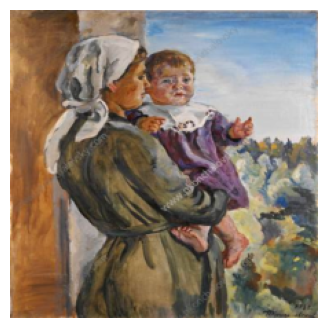

Emotion Label: 2
Generated:    group storm calm brushstrokes walking attack word small old brushstrokes walking attack edge onto dresses motion loving village heaven have
Ground Truth: a woman and child in a <unk> outfit reminds me of a <unk> being <unk> in the new world
--------------------------------------------------


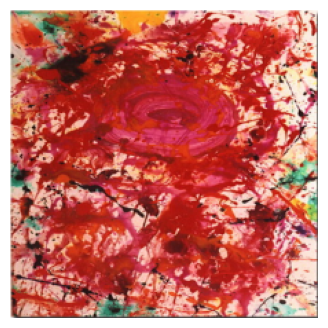

Emotion Label: 6
Generated:    group storm calm the shape cannot bent empty stroke every preparing understand bringing kiss clouds looking absolutely playful simply animal
Ground Truth: this is horrible this looks like it is a bloody mess from a violent <unk>
--------------------------------------------------


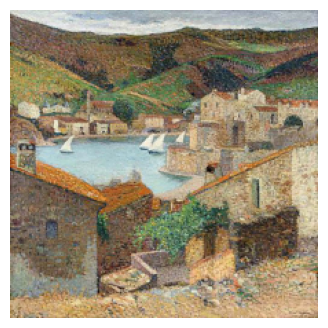

Emotion Label: 3
Generated:    group storm calm brushstrokes walking attack word small old brushstrokes walking attack edge onto dresses motion loving village heaven have
Ground Truth: sailboats on top of a clear blue lake surrounded by a warm village
--------------------------------------------------


--- 2. Calculating BLEU Score ---
Note: This might take a minute as it generates captions token-by-token...
--- Calculating BLEU Score (Autoregressive) ---
Transformer Average BLEU-1: 0.0195

EVALUATION COMPLETE


In [37]:
# --- EVALUATION DRIVER CELL ---

# 1. Check if model exists (Adjust name if you called it 'model' instead of 'model_transformer')
if 'model_transformer' not in globals():
    print("Error: 'model_transformer' is not defined. Did you run the training cell?")
    # Fallback in case you named it simply 'model'
    if 'model' in globals():
        print("Found 'model'. Using that instead.")
        model_transformer = model
    else:
        raise NameError("Please define your trained model variable.")

# 2. Ensure Model is in Evaluation Mode (Critical for Transformers)
model_transformer.eval()

print("==========================================")
print("STARTING TRANSFORMER EVALUATION")
print("==========================================")

# 3. Run Qualitative Evaluation (Visuals)
try:
    print("\n--- 1. Generating Captions for Images ---")
    # This will display images and print the generated vs ground truth text
    evaluate_transformer_visual(
        model=model_transformer, 
        dataset=train_dataset, 
        loader=train_loader, 
        num_samples=3 # Change this to see more images
    )
except Exception as e:
    print(f"\n[!] Error in Visual Evaluation: {e}")
    import traceback
    traceback.print_exc()

print("\n==========================================")

# 4. Run Quantitative Evaluation (BLEU)
try:
    print("\n--- 2. Calculating BLEU Score ---")
    print("Note: This might take a minute as it generates captions token-by-token...")
    
    # We calculate on just 5 batches to save time. 
    # Increase num_batches for a more accurate score.
    calculate_bleu_transformer(
        model=model_transformer, 
        loader=train_loader, 
        dataset=train_dataset, 
        num_batches=5 
    )
except Exception as e:
    print(f"\n[!] Error in BLEU Calculation: {e}")
    import traceback
    traceback.print_exc()

print("\n==========================================")
print("EVALUATION COMPLETE")